* 使用行业内的排序，进行因子测试；与回归版本，以及原始因子值版本进行比较。本部分参考自《QEPM》 p.p 117
* 请在环境变量中设置`DB_URI`指向数据库

# 参数设定
--------------

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from PyFin.api import *
from alphamind.api import *

factor = "EMA5D"
universe = Universe('zz800')
start_date = '2020-01-01'
end_date = '2020-02-21'
freq = '10b'
category = 'sw'
level = 1
horizon = map_freq(freq)

engine = SqlEngine(os.environ['DB_URI'])

ref_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
sample_date = '2018-01-04'
sample_codes = engine.fetch_codes(sample_date, universe)

sample_industry = engine.fetch_industry(sample_date, sample_codes, category=category, level=level)

In [2]:
sample_industry.head()

,code,industry_code,industry
0,2010001130,110000,农林牧渔
1,2010001343,110000,农林牧渔
2,2010001388,110000,农林牧渔
3,2010001440,110000,农林牧渔
4,2010001484,110000,农林牧渔


# 样例因子
--------------------

我们下面分三种方法，分别考查这几种方法在避免行业集中上面的效果：

* 使用原始因子的排序；
* 使用原始因子在行业内的排序；
* 使用原始因子在行业哑变量上回归后得到的残差排序。

## 1. 原始因子排序
--------------------

In [3]:
factor1 = {'f1': CSQuantiles(factor)}
sample_factor1 = engine.fetch_factor(sample_date, factor1, sample_codes)
sample_factor1 = pd.merge(sample_factor1, sample_industry[['code', 'industry']], on='code')

In [4]:
sample_factor1.sort_values('f1', ascending=False).head(15)

,f1,code,chgPct,secShortName,industry
158,0.93875,2010000438,2.9629,贵州茅台,食品饮料
790,0.93750,2010024107,4.0481,吉比特,传媒
379,0.93625,2010001184,-1.3759,长春高新,医药生物
796,0.93500,2010025522,2.3616,欧派家居,轻工制造
549,0.93375,2010003350,4.9892,洋河股份,食品饮料
353,0.93250,2010001081,1.5226,云南白药,医药生物
777,0.93125,2010021893,0.1602,汇顶科技,电子
737,0.93000,2010009579,3.0056,华友钴业,有色金属
421,0.92875,2010001333,2.5834,五 粮 液,食品饮料
756,0.92750,2010015152,-0.4647,飞科电器,家用电器


对于原始因子，如果我们不做任何行业上面的处理，发现我们选定的alpha因子`CFO2EV`较大的股票集中于银行和大金融板块。

## 2. 行业内排序因子
----------------------

这里我们使用调整后的申万行业分类作为行业标签：

In [5]:
factor2 = {'f2': CSQuantiles(factor)}
sample_factor2 = engine.fetch_factor(sample_date, factor2, sample_codes)
sample_factor2 = pd.merge(sample_factor2, sample_industry[['code', 'industry']], on='code')
sample_factor2.sort_values('f2', ascending=False).head(15)

,f2,code,chgPct,secShortName,industry
158,0.93875,2010000438,2.9629,贵州茅台,食品饮料
790,0.93750,2010024107,4.0481,吉比特,传媒
379,0.93625,2010001184,-1.3759,长春高新,医药生物
796,0.93500,2010025522,2.3616,欧派家居,轻工制造
549,0.93375,2010003350,4.9892,洋河股份,食品饮料
353,0.93250,2010001081,1.5226,云南白药,医药生物
777,0.93125,2010021893,0.1602,汇顶科技,电子
737,0.93000,2010009579,3.0056,华友钴业,有色金属
421,0.92875,2010001333,2.5834,五 粮 液,食品饮料
756,0.92750,2010015152,-0.4647,飞科电器,家用电器


使用行业内的排序，则行业分布会比较平均。

## 3. 使用回归将因子行业中性
--------------------------------

还有一种思路，使用线性回归，以行业为哑变量，使用回归后的残差作为因子的替代值，做到行业中性：

In [6]:
factor3 = {'f3': factor}
sample_factor3 = engine.fetch_factor(sample_date, factor3, sample_codes)
risk_cov, risk_exp = engine.fetch_risk_model(sample_date, sample_codes)
sample_factor3 = pd.merge(sample_factor3, sample_industry[['code', 'industry']], on='code')
sample_factor3 = pd.merge(sample_factor3, risk_exp, on='code')

In [7]:
raw_factors = sample_factor3['f3'].values
industry_exp = sample_factor3[industry_styles + ['COUNTRY']].values.astype(float)
processed_values = factor_processing(raw_factors, pre_process=[], risk_factors=industry_exp, post_process=[percentile])
sample_factor3['f3'] = processed_values

In [8]:
sample_factor3 = sample_factor3[['code', 'f3', 'industry']]
sample_factor3.sort_values('f3', ascending=False).head(15)

,code,f3,industry
799,2010026653,1.000000,非银金融
262,2010000791,0.998748,传媒
272,2010000818,0.997497,国防军工
271,2010000811,0.996245,公用事业
270,2010000806,0.994994,房地产
269,2010000805,0.993742,机械设备
268,2010000804,0.992491,国防军工
267,2010000798,0.991239,食品饮料
266,2010000797,0.989987,公用事业
265,2010000796,0.988736,电气设备


我们发现这种方法的效果并不是很好。调整的幅度并不是很大，同时仍然存在着集中于大金融板块的问题。

# 回测结果
------------------

我们使用简单等权重做多前20%支股票，做空后20%的方法，考察三种方法的效果：

In [9]:
factors = {
    'raw': CSQuantiles(factor),
    'peer quantile': CSQuantiles(factor),
    'risk neutral': LAST(factor)
}

In [10]:
df_ret = pd.DataFrame(columns=['raw', 'peer quantile', 'risk neutral'])
df_ic = pd.DataFrame(columns=['raw', 'peer quantile', 'risk neutral'])

for date in ref_dates:
    ref_date = date.strftime('%Y-%m-%d')
    codes = engine.fetch_codes(ref_date, universe)

    total_factor = engine.fetch_factor(ref_date, factors, codes)
    risk_cov, risk_exp = engine.fetch_risk_model(ref_date, codes)
    industry = engine.fetch_industry(ref_date, codes, category=category, level=level)
    rets = engine.fetch_dx_return(ref_date, codes, horizon=horizon, offset=1)
    total_factor = pd.merge(total_factor, industry[['code', 'industry']], on='code')
    total_factor = pd.merge(total_factor, risk_exp, on='code')
    total_factor = pd.merge(total_factor, rets, on='code').dropna()

    raw_factors = total_factor['risk neutral'].values
    industry_exp = total_factor[industry_styles + ['COUNTRY']].values.astype(float)
    processed_values = factor_processing(raw_factors, pre_process=[], risk_factors=industry_exp, post_process=[percentile])
    total_factor['risk neutral'] = processed_values

    total_factor[['f1_d', 'f2_d', 'f3_d']] = (total_factor[['raw', 'peer quantile', 'risk neutral']] >= 0.8) * 1.
    total_factor.loc[total_factor['raw'] <= 0.2, 'f1_d'] = -1.
    total_factor.loc[total_factor['peer quantile'] <= 0.2, 'f2_d'] = -1.
    total_factor.loc[total_factor['risk neutral'] <= 0.2, 'f3_d'] = -1.
    total_factor[['f1_d', 'f2_d', 'f3_d']] /= np.abs(total_factor[['f1_d', 'f2_d', 'f3_d']]).sum(axis=0)

    ret_values = total_factor.dx.values @ total_factor[['f1_d', 'f2_d', 'f3_d']].values
    df_ret.loc[date] = ret_values
    
    ic_values = total_factor[['dx', 'raw', 'peer quantile', 'risk neutral']].corr().values[0, 1:]
    df_ic.loc[date] = ic_values
    print(f"{date} is finished")

2020-01-02 00:00:00 is finished
2020-01-16 00:00:00 is finished
2020-02-07 00:00:00 is finished
2020-02-21 00:00:00 is finished


<AxesSubplot:>

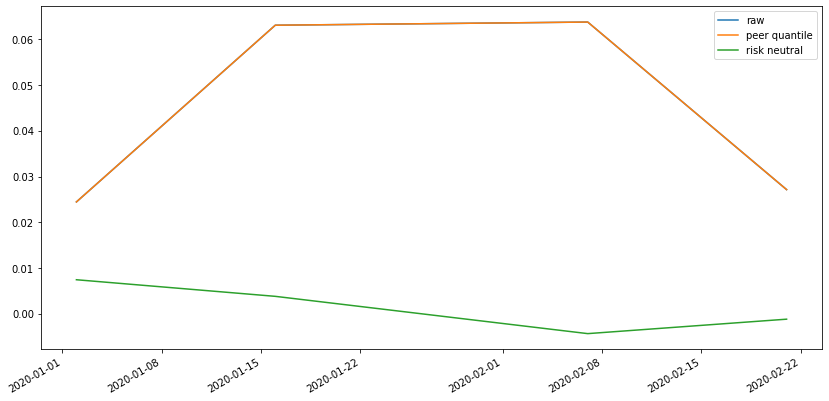

In [11]:
df_ret.cumsum().plot(figsize=(14, 7))

<AxesSubplot:>

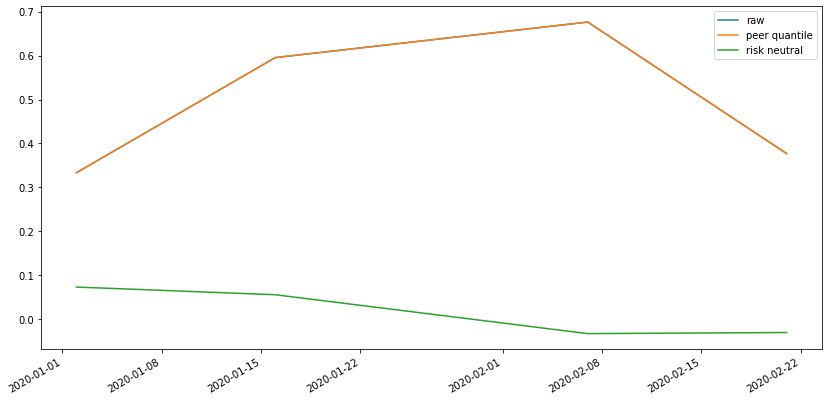

In [12]:
df_ic.cumsum().plot(figsize=(14, 7))